In [1]:
import os
import numpy as np
import pandas as pd
import h5py
import nibabel as nb
import matplotlib.pyplot as plt
from nilearn import plotting
import seaborn as sns
import matlab.engine
import matlab
import nipype.interfaces.freesurfer as fs
from nipype.interfaces.base import CommandLine


#### start matlab engine

In [2]:
def matlab_init_surfstat():
    global eng
    eng = matlab.engine.start_matlab()
    addpath = eng.addpath('../../BrainStat/surfstat/matlab')

matlab_init_surfstat()

### resample T1w-T2w-Ratios (native) to MNI Space (template)

In [2]:
subjlist = '../data/subjectList1200.txt'
f = open(subjlist); mylist = f.read().split("\n"); f.close() 
subjlist = joinedlist = mylist[:-1]
len(subjlist)

1113

In [5]:
ddir = '../data/'
odir = '../data/hcp_MNI_T1wT2w/'


for subjid in subjlist:

    # existing files
    t1t2_native = os.path.join(ddir, 
                               'hcp-structural-preprocessed/%s/T1w/T1wDividedByT2w.nii.gz' 
                               % (subjid))
    t1_native   = os.path.join(ddir, 
                               'hcp-structural-preprocessed/%s/T1w/T1w_acpc_dc.nii.gz' 
                               %(subjid))
    t1_mni_trf  = os.path.join(ddir, 
                               'hcp_MNI_T1w/%s/MNINonLinear/xfms/acpc_dc2standard.nii.gz' 
                               % (subjid))

    fsl_mni     = '../data/MNI152_T1_1mm_brain.nii.gz'

    # will be generated 
    if not os.path.exists(os.path.join(odir, subjid)):
        os.makedirs(os.path.join(odir, subjid))
        
    t1t2_mni = os.path.join(odir, subjid, 'T1wDividedByT2w_mni.nii.gz')


    # Here we go...
    if os.path.isfile(t1t2_native) and os.path.isfile(t1_native) \
    and os.path.isfile(t1_mni_trf) and not os.path.isfile(t1t2_mni):        

        print(subjid)

        # nipype wrapper for $wb_command
        cli = CommandLine(command = 'wb_command')
        cli.inputs.args = ('-volume-warpfield-resample %s %s %s  ENCLOSING_VOXEL %s -fnirt %s ' 
                           % (t1t2_native, t1_mni_trf, fsl_mni, t1t2_mni, t1_native))
        cli.run()    


### resample T1w-T2w-Ratios (MNI) along hippocampus surfaces

In [3]:
bladesdir = '../data/bladesMni/'
workdir   = '../data/bladesMniGifti_T1wT2w/'
t1t2dir   = '../data/hcp_MNI_T1wT2w/'

subjlist = '../data/subjectList1200.txt'
f = open(subjlist); mylist = f.read().split("\n"); f.close() 
subjlist = joinedlist = mylist[:-1]
len(subjlist)


1113

In [7]:
roi_strings = ['L_SUB', 'L_CA', 'L_DG', 'R_SUB', 'R_CA', 'R_DG']                                        

for subjid in subjlist:

    for roi in roi_strings:
    
        # get existing files
        fname     = os.path.join(bladesdir, 'HCP_%s_%s_skelFinal.obj' % (subjid, roi))  
        volfile   = os.path.join(t1t2dir, subjid, 'T1wDividedByT2w_mni.nii.gz')

        if os.path.isfile(fname) and os.path.isfile(volfile): 

            # ... will be generated
            fsFile    = os.path.join(workdir, os.path.basename(fname)[:-4] + '.fs')
            giftiFile = os.path.join(workdir, os.path.basename(fname)[:-4] + '.surf.gii')
            vol2hipp  = os.path.join(workdir, os.path.basename(fname)[:-4] + '.shape.gii')

            if not os.path.isfile(vol2hipp):

                # read hippocampal surface (*obj) and write in freesurfer format (*fs)
                data = eng.SurfStatReadSurf(fname)
                eng.SurfStatWriteSurf1(fsFile, data);

                # nipype wrapper for $ mris_convert
                mris = fs.MRIsConvert()
                mris.inputs.in_file  = fsFile
                mris.inputs.out_file = giftiFile
                mris.run() 

                # nipype wrapper for $wb_command
                cli = CommandLine(command = 'wb_command')
                cli.inputs.args = ('-volume-to-surface-mapping %s %s %s  -trilinear ' 
                                   % (volfile, giftiFile, vol2hipp))
                cli.run()

                # read data from the gifti file
                qc_data = nb.load(vol2hipp).agg_data()




## sanity check: T1w/T2w mean distributions

In [4]:

# this data frame will be filled out through this jupyter notebook

qc_file = '../data/qualityControl_Bayrak.xlsx'

df = pd.read_excel(qc_file, index_col=0)
df.index = df.index.map(str)

DF = df.copy(deep=True)


In [6]:
#DF

### write in the qc file (mean t1w-t2w-ratios along the subfields)

In [5]:
workdir   = '../data/bladesMniGifti_T1wT2w/'

for subjid in subjlist:

    # filename for t1w-t2w ratio, resampled along hippocampus
    vol2hipp_L_SUB = os.path.join(workdir, 'HCP_%s_L_SUB_skelFinal.shape.gii' % (subjid))  
    vol2hipp_R_SUB = os.path.join(workdir, 'HCP_%s_R_SUB_skelFinal.shape.gii' % (subjid))  
    vol2hipp_L_DG  = os.path.join(workdir, 'HCP_%s_L_DG_skelFinal.shape.gii' % (subjid))  
    vol2hipp_R_DG  = os.path.join(workdir, 'HCP_%s_R_DG_skelFinal.shape.gii' % (subjid))  
    vol2hipp_L_CA  = os.path.join(workdir, 'HCP_%s_L_CA_skelFinal.shape.gii' % (subjid))  
    vol2hipp_R_CA  = os.path.join(workdir, 'HCP_%s_R_CA_skelFinal.shape.gii' % (subjid))  

    if os.path.isfile(vol2hipp_L_SUB): 
        # read data from the gifti file
        qc_data_L_SUB = nb.load(vol2hipp_L_SUB).agg_data()
        # set mean t1w-t2w ratios at dataframe
        DF.at[subjid, 't1-t2-LSUB'] = qc_data_L_SUB.mean()

    if os.path.isfile(vol2hipp_R_SUB):
        qc_data_R_SUB = nb.load(vol2hipp_R_SUB).agg_data()
        DF.at[subjid, 't1-t2-RSUB'] = qc_data_R_SUB.mean()
    
    if os.path.isfile(vol2hipp_L_DG):
        qc_data_L_DG  = nb.load(vol2hipp_L_DG).agg_data()
        DF.at[subjid, 't1-t2-LDG']  = qc_data_L_DG.mean()
        
    if os.path.isfile(vol2hipp_R_DG):
        qc_data_R_DG  = nb.load(vol2hipp_R_DG).agg_data()
        DF.at[subjid, 't1-t2-RDG']  = qc_data_R_DG.mean()
        
    if os.path.isfile(vol2hipp_L_CA):
        qc_data_L_CA  = nb.load(vol2hipp_L_CA).agg_data()
        DF.at[subjid, 't1-t2-LCA']  = qc_data_L_CA.mean()
        
    if os.path.isfile(vol2hipp_R_CA):
        qc_data_R_CA  = nb.load(vol2hipp_R_CA).agg_data()
        DF.at[subjid, 't1-t2-RCA']  = qc_data_R_CA.mean()


### plot mean T1w/T2w ratios for left hem. subfields

0 t1-t2-LSUB
1 t1-t2-LCA
2 t1-t2-LDG


Text(0.5, 1.0, 'T1w-T2w-ratio')

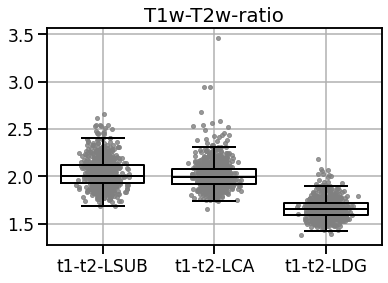

In [6]:
sns.set_context("talk", font_scale=1.1)

colstoplot = ['t1-t2-LSUB', 't1-t2-LCA', 't1-t2-LDG']


for i,d in enumerate(colstoplot):
    print(i, d)
    y = DF[d]
    x = np.random.normal(i+1, 0.08, len(y))
    plt.plot(x, y, 
             marker="o", 
             markeredgewidth = 1,
             linestyle='None',
             color='grey', 
             markersize=4,  
             alpha=0.8)

ax = DF.boxplot(column=colstoplot,
                fontsize=17, 

                color=dict(boxes='k', whiskers='k', medians='k', caps='k'),
                boxprops=dict(linestyle='-', linewidth=2),
                flierprops=dict(linestyle='-', linewidth=2),
                medianprops=dict(linestyle='-', linewidth=2),
                whiskerprops=dict(linestyle='-', linewidth=2),
                capprops=dict(linestyle='-', linewidth=2),
                widths=(0.75, 0.75, 0.75),
                showfliers=False,)


ax.set_title("T1w-T2w-ratio")    
#ax.set(ylim=(1.2, 3))
#plt.savefig('../figures/method_t1t2-ratios_left.png', dpi=300)

### plot mean T1w/T2w ratios for right hem. subfields

0 t1-t2-RSUB
1 t1-t2-RCA
2 t1-t2-RDG


/data/u_bayrak_software/anaconda3/envs/hippoc/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 1.0, 'T1w-T2w-ratio')

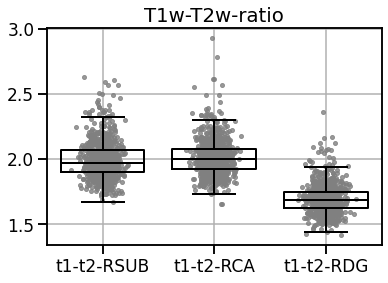

In [7]:
sns.set_context("talk", font_scale=1.1)

colstoplot = ['t1-t2-RSUB', 't1-t2-RCA', 't1-t2-RDG']


for i,d in enumerate(colstoplot):
    print(i, d)
    y = DF[d]
    x = np.random.normal(i+1, 0.08, len(y))
    plt.plot(x, y, 
             marker="o", 
             markeredgewidth = 1,
             linestyle='None',
             color='grey', 
             markersize=4,  
             alpha=0.8)
    

ax = DF.boxplot(column=colstoplot,
                fontsize=17, 

                color=dict(boxes='k', whiskers='k', medians='k', caps='k'),
                boxprops=dict(linestyle='-', linewidth=2),
                flierprops=dict(linestyle='-', linewidth=2),
                medianprops=dict(linestyle='-', linewidth=2),
                whiskerprops=dict(linestyle='-', linewidth=2),
                capprops=dict(linestyle='-', linewidth=2),
                widths=(0.75, 0.75, 0.75),
                showfliers=False,)


ax.set_title("T1w-T2w-ratio")    
#ax.set(ylim=(1.2, 3))
#plt.savefig('../figures/method_t1t2-ratios_right.png', dpi=300)

# QC-Step 1) identify subjects with HCP-issues

In [8]:
# get the QC file from the vos-de-Wael et al, 2018

qc_file_pnas = '../data/qualityControl_VosdeWael.xlsx'

df_pnas = pd.read_excel(qc_file_pnas, index_col=0)
df_pnas.index = df_pnas.index.map(str)

DF_pnas = df_pnas.copy(deep=True)

In [9]:

k = 0    
for subjS900 in DF_pnas.index:
    if not pd.isnull(DF.at[subjS900, 'HCP-issues']):
        k += 1
        print(subjS900, DF.at[subjS900, 'HCP-issues'])

105620 A
110613 AB
111312 A
112112 A
113821 B
114924 A
122620 A
124422 A
134829 A
139637 AB
140117 A
145127 A
147737 A
148840 A
150019 A
156435 A
163432 A
166438 A
168139 AB
175035 B
176239 B
178849 A
180836 A
181131 A
190132 A
195849 A
199655 A
199958 B
200210 A
201515 AB
224022 A
270332 A
415837 B
433839 AB
465852 B
522434 A
552544 A
628248 A
656657 AB
709551 A
734045 A
767464 AB
872764 B
958976 A
965367 B
987983 B
994273 AB


In [10]:
k

47

In [11]:
len(DF_pnas.index)

898

In [12]:
len(DF_pnas.index) - k

851

# QC-Step 2) subjects with complete four HCP scan sessions

In [13]:
# data dir
ddir     = '../data/'  
                
glassdir = os.path.join(ddir, 'glasserTimeseries/');    # cortex t-series
hippdir  = os.path.join(ddir, 'smoothTimeseries/');     # hippocampus t-series


In [14]:
# it is HCP data, so there will be 4 scans
scans = ['rfMRI_REST1_LR', 'rfMRI_REST1_RL', 
         'rfMRI_REST2_LR', 'rfMRI_REST2_RL'];

# hippocampus segmentations
rois = ['L_SUB', 'L_CA', 'L_DG', 'R_SUB', 'R_CA', 'R_DG']

j = 0

for subjid in subjlist:

    objname1 = os.path.join(ddir, 'bladesMni/HCP_%s_L_SUB_skelFinal.obj' % (subjid))
    objname2 = os.path.join(ddir, 'bladesMni/HCP_%s_R_SUB_skelFinal.obj' % (subjid))
    objname3 = os.path.join(ddir, 'bladesMni/HCP_%s_L_DG_skelFinal.obj' % (subjid))
    objname4 = os.path.join(ddir, 'bladesMni/HCP_%s_R_DG_skelFinal.obj' % (subjid))
    objname5 = os.path.join(ddir, 'bladesMni/HCP_%s_L_CA_skelFinal.obj' % (subjid))
    objname6 = os.path.join(ddir, 'bladesMni/HCP_%s_R_CA_skelFinal.obj' % (subjid))

    # check if segmentation files exist
    if os.path.isfile(objname1) and os.path.isfile(objname2) \
    and os.path.isfile(objname3) and os.path.isfile(objname4) \
    and os.path.isfile(objname5) and os.path.isfile(objname6):


        # check if timeseries exist
        subj_glass_file = os.path.join(glassdir, 'HCP_%s_glasserTimeseries.mat' % (subjid))
        subj_hipp_file  = os.path.join(hippdir, 'HCP_%s_smoothTimeseries.mat' % (subjid))

        if os.path.isfile(subj_glass_file) and os.path.isfile(subj_hipp_file):

            #  HDF reader for matlab v7.3 files
            f_subj_glass = h5py.File(subj_glass_file, 'r')
            f_subj_hipp  = h5py.File(subj_hipp_file, 'r')

            # check the data for each of the 4 scans
            scan_check = []
            for scan in scans:
                if scan in f_subj_glass.keys():
                    scan_check.append(True)
                    
            if len(scan_check) == 4:
                DF.at[subjid, '4scans'] = int(1)
            else:
                DF.at[subjid, '4scans'] = int(0)
            
            j += 1


In [15]:
m = 0    
y = 0

for subjS900 in DF_pnas.index:
    if pd.isnull(DF.at[subjS900, 'HCP-issues']):
        y += 1
        if DF.at[subjS900, '4scans'] == 1:
            m += 1

In [16]:
m

782

# QC-Step 3) visual inspections on SurfPatch subfield segmentations

### for MANUAL visualizing purposes, T1w_restore (mni) resampled along hippocampus shells

In [17]:
shellsdir = '../data/shellsMni/'
outdir    = '../data/shellsMniGifti'
t1dir     = '../data/hcp_MNI_T1w/'

subjlist = '../data/subjectList1200.txt'
f = open(subjlist); mylist = f.read().split("\n"); f.close() 
subjlist = joinedlist = mylist[:-1]
len(subjlist)

1113

### L_SUB, L_CA, L_DG, R_SUB, R_CA, R_DG gifti

In [13]:
roi_strings = ['L_SUB', 'L_CA', 'L_DG', 'R_SUB', 'R_CA', 'R_DG']                                        

for subjid in subjlist:

    for roi in roi_strings:

        # get existing files
        fname     = os.path.join(shellsdir, 'HCP_%s_%s.obj' % (subjid, roi))  
        volfile   = os.path.join(t1dir, subjid, 'MNINonLinear/T1w_restore.nii.gz')

        if os.path.isfile(fname) and os.path.isfile(volfile): 

            # ... will be generated
            fsFile    = os.path.join(outdir, os.path.basename(fname)[:-4] + '.fs')
            giftiFile = os.path.join(outdir, os.path.basename(fname)[:-4] + '.surf.gii')
            vol2hipp  = os.path.join(outdir, os.path.basename(fname)[:-4] + '.shape.gii')

            if not os.path.isfile(vol2hipp):

                # read hippocampal surface (*obj) and write in freesurfer format (*fs)
                data = eng.SurfStatReadSurf(fname)
                eng.SurfStatWriteSurf1(fsFile, data);

                # nipype wrapper for $ mris_convert
                mris = fs.MRIsConvert()
                mris.inputs.in_file  = fsFile
                mris.inputs.out_file = giftiFile
                mris.run() 

                # nipype wrapper for $wb_command
                cli = CommandLine(command = 'wb_command')
                cli.inputs.args = ('-volume-to-surface-mapping %s %s %s  -trilinear ' 
                                   % (volfile, giftiFile, vol2hipp))
                cli.run()


### read & write man vis. quality check in main DF

In [18]:
qc_file = '../data/qualityControl_Bayrak_manualViz.xlsx'

dfMAN = pd.read_excel(qc_file, index_col=0)
dfMAN.index = dfMAN.index.map(str)

DFMAN = dfMAN.copy(deep=True)

subjlist = DF.index

for subj in subjlist:
    
    if DFMAN.at[subj, 't1-t2-man-viz'] == 1:
        DF.at[subj, 't1-t2-man-viz'] = 1
    
    elif DFMAN.at[subj, 't1-t2-man-viz'] == 0:
        DF.at[subj, 't1-t2-man-viz'] == 0

### input PNAS study QC values in our DF

In [19]:
for subjS900 in subjlist:

    if subjS900 in DF_pnas.index :
        
        if DF_pnas.at[subjS900, 'Grade'] > 0: 
            
            DF.at[subjS900, 'pnas'] = 1
    
        elif DF_pnas.at[subjS900, 'Grade'] <= 0: 
            
            DF.at[subjS900, 'pnas'] = 0
    


In [20]:
m = 0    
y = 0
h = 0


for subjS900 in DF_pnas.index:
    if pd.isnull(DF.at[subjS900, 'HCP-issues']):
        y += 1

        if DF.at[subjS900, '4scans'] == 1:
            m += 1

            if DF.at[subjS900, 'pnas'] > 0  or DF.at[subjS900, 't1-t2-man-viz'] == 1: 
                h += 1
                

In [21]:
h

740

In [ ]:
# save the surviving 740 subjects to obtaine a group-level FC

qc_file = '../data/qualityControl_Bayrak_v03.xlsx'

df = pd.read_excel(qc_file, index_col=0)
df.index = df.index.map(str)

DF = df.copy(deep=True)

subjlist = DF.index

f1 = open('../data/subjectListS900_QC.txt', 'a')

x = 0
for subj in subjlist:
    if DF.at[subj, 'inclusion'] == 1:
        x += 1
        f1.write(subj + "\n")
f1.close()


# QC-Step 4) correlations between individual- and group-level FC

In [22]:
import os
import h5py
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns


In [23]:
ddir      = '../data/'                                          #  data dir
cordir    = '../data/tout_cortex/'
grodir    = '../data/tout_group'

# final subject list after QC         
subjlist = os.path.join(ddir, 'subjectListS900_QC.txt');       # 740 subjects
f = open(subjlist); mylist = f.read().split("\n"); f.close() 
mylist =  mylist[:-1] 
totnum = len(mylist)

print('We have now %i subjects... ' % totnum)


We have now 740 subjects... 


In [24]:
# get group-level cortex-to-subfield connectivity

with h5py.File(os.path.join(grodir, 'cortex740_LSUB.h5'), "r") as f:  
    avg_LSUB = np.array(f['LSUB']) 

with h5py.File(os.path.join(grodir, 'cortex740_RSUB.h5'), "r") as f:  
    avg_RSUB = np.array(f['RSUB']) 

with h5py.File(os.path.join(grodir, 'cortex740_LCA.h5'), "r") as f:  
    avg_LCA = np.array(f['LCA']) 

with h5py.File(os.path.join(grodir, 'cortex740_RCA.h5'), "r") as f:  
    avg_RCA = np.array(f['RCA']) 

with h5py.File(os.path.join(grodir, 'cortex740_LDG.h5'), "r") as f:  
    avg_LDG = np.array(f['LDG']) 
    
with h5py.File(os.path.join(grodir, 'cortex740_RDG.h5'), "r") as f:  
    avg_RDG = np.array(f['RDG']) 
    
avg_SUB = (avg_LSUB + avg_RSUB)/2
avg_CA  = (avg_LCA + avg_RCA)/2
avg_DG  = (avg_LDG + avg_RDG)/2


In [25]:
len(mylist)

740

### compute the individual correlations

In [47]:
num = avg_SUB.shape[0]

k = 0
for subjID in mylist:
    
    subjsub_L = os.path.join(cordir, subjID + '_cortex_LSUB.h5')
    subjsub_R = os.path.join(cordir, subjID + '_cortex_RSUB.h5')
    
    with h5py.File(subjsub_L, "r") as f:        
        subjsubdata_L = np.array(f[subjID])
    
    with h5py.File(subjsub_R, "r") as f:        
        subjsubdata_R = np.array(f[subjID])

    subjsubdata = (subjsubdata_L + subjsubdata_R) / 2   
    
    subjca_L = os.path.join(cordir, subjID + '_cortex_LCA.h5')
    subjca_R = os.path.join(cordir, subjID + '_cortex_RCA.h5')
    
    with h5py.File(subjca_L, "r") as f:        
        subjcadata_L = np.array(f[subjID])

    with h5py.File(subjca_R, "r") as f:        
        subjcadata_R = np.array(f[subjID])

    subjcadata = (subjcadata_L + subjcadata_R) / 2      
    
    subjdg_L = os.path.join(cordir, subjID + '_cortex_LDG.h5')
    subjdg_R = os.path.join(cordir, subjID + '_cortex_RDG.h5')
    
    with h5py.File(subjdg_L, "r") as f:        
        subjdgdata_L = np.array(f[subjID])

    with h5py.File(subjdg_R, "r") as f:        
        subjdgdata_R = np.array(f[subjID])
    
    subjdgdata = (subjdgdata_L + subjdgdata_R) / 2      
       
    DF.at[subjID, 'corrSUB'] = pearsonr(avg_SUB.reshape(num), subjsubdata.reshape(num))[0]
    DF.at[subjID, 'corrCA']  = pearsonr(avg_CA.reshape(num), subjcadata.reshape(num))[0]
    DF.at[subjID, 'corrDG']  = pearsonr(avg_DG.reshape(num), subjdgdata.reshape(num))[0]

    if DF.at[subjID, 'corrSUB'] >= 0.45 and DF.at[subjID,'corrCA'] >= 0.45 and DF.at[subjID,'corrDG'] >=0.45:
        k += 1
        DF.at[subjID, 'corr-no'] = 1    
    
    else:
        print(subjID, DF.at[subjID,'corrSUB'], DF.at[subjID,'corrSUB'], DF.at[subjID,'corrSUB'])
        DF.at[subjID,'corr-no'] = 0 
    
    #df.to_excel('../data/tout_group/cortex_corr_indiv.xlsx')

111716 0.5340041552674235 0.5340041552674235 0.5340041552674235
148032 0.6190339010993898 0.6190339010993898 0.6190339010993898
149236 0.571172987719664 0.571172987719664 0.571172987719664
154835 0.660900435543258 0.660900435543258 0.660900435543258
162935 0.5877979079506098 0.5877979079506098 0.5877979079506098
167238 0.6028237387577474 0.6028237387577474 0.6028237387577474
171431 0.5769454459514572 0.5769454459514572 0.5769454459514572
180129 0.6217845644817634 0.6217845644817634 0.6217845644817634
192035 0.5206749476076504 0.5206749476076504 0.5206749476076504
195041 0.6329490592840916 0.6329490592840916 0.6329490592840916
197348 0.6769558102688822 0.6769558102688822 0.6769558102688822
204521 0.640759730569356 0.640759730569356 0.640759730569356
211720 0.4863120983776601 0.4863120983776601 0.4863120983776601
284646 0.41430855161114954 0.41430855161114954 0.41430855161114954
309636 0.6251210447199278 0.6251210447199278 0.6251210447199278
310621 0.6769268744758212 0.6769268744758212 0

In [76]:
m = 0    
y = 0
h = 0
k = 0

for subjS900 in DF_pnas.index:
    if pd.isnull(DF.at[subjS900, 'HCP-issues']):
        y += 1

        if DF.at[subjS900, '4scans'] == 1:
            m += 1

            if DF.at[subjS900, 'pnas'] > 0  or DF.at[subjS900, 't1-t2-man-viz'] == 1: 
                h += 1
                
                if DF.at[subjS900, 'corr-no'] == 1: 
                    k += 1
                    
                    DF.at[subjS900, 'INCLUSION'] = 1
                


In [52]:
h

740

In [53]:
k

709

# save out subject ID's passing all of the QC steps

In [77]:
# get HCP - S900 subject list        
subjlist = '../data/subjectListS900_QC_gr.txt'
f = open(subjlist); mylist = f.read().split("\n"); f.close() 
subjlist = joinedlist = mylist[:-1]



### plot individual correlations for n=740 subjects

0 corrSUB
1 corrCA
2 corrDG


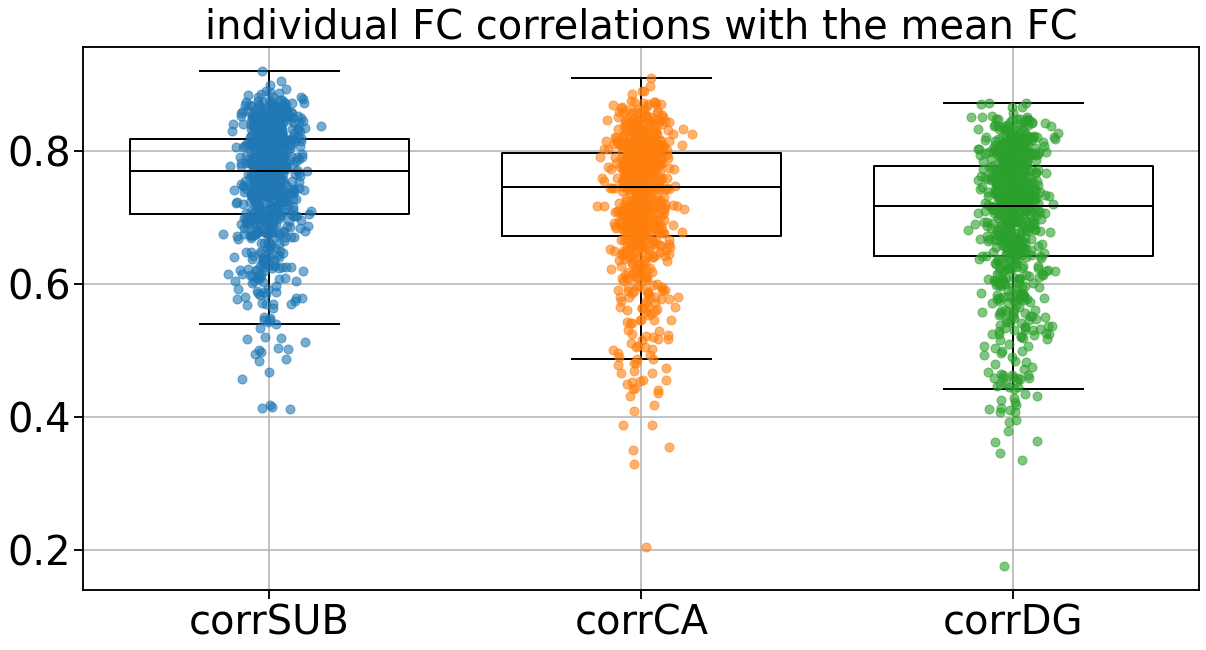

In [54]:


sns.set_context("talk", font_scale=1.1)


colstoplot = ['corrSUB', 'corrCA', 'corrDG']

ax = DF.boxplot(column=colstoplot,                        
                figsize=(20,10),
                color=dict(boxes='k', whiskers='k', medians='k', caps='k'),
                fontsize=40, 
                boxprops=dict(linestyle='-', linewidth=2),
                flierprops=dict(linestyle='-', linewidth=2),
                medianprops=dict(linestyle='-', linewidth=2),
                whiskerprops=dict(linestyle='-', linewidth=2),
                capprops=dict(linestyle='-', linewidth=2),
                widths=(0.75, 0.75, 0.75),
               showfliers=False)

ax.set_title("individual FC correlations with the mean FC", fontsize=40)

for i,d in enumerate(colstoplot):
    print(i, d)
    y = DF[d]
    x = np.random.normal(i+1, 0.04, len(y))
    plt.plot(x, y, 
             marker="o", linestyle="None", alpha=0.6)

#plt.savefig('../figures/individual_correlations.png', dpi=300)


### plot correlations only for SUB

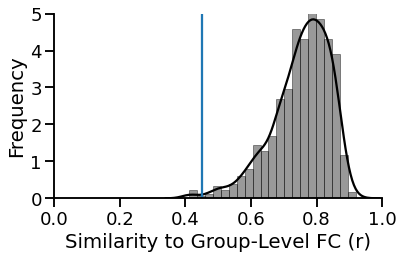

In [56]:
sns.set_context("talk", font_scale=1.1)
ax = sns.distplot(DF['corrSUB'], 
                  hist_kws=dict(edgecolor="k", linewidth=1),
                  color='k')
sns.despine()
ax.set(xlim=(0,1))
ax.set(ylabel='Frequency')
ax.set(xlabel='Similarity to Group-Level FC (r)')
plt.axvline(0.45, 0, 5)
ax.set(ylim=(0,5))
plt.tight_layout()
#plt.savefig('../figures/qc_corr_sub.png',
#            dpi=300)

### plot correlations only for CA

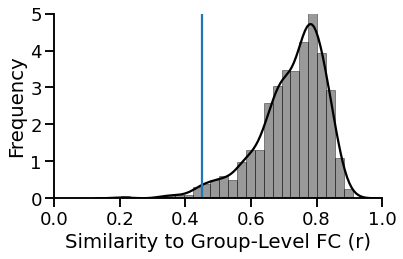

In [59]:
sns.set_context("talk", font_scale=1.1)
ax = sns.distplot(DF['corrCA'], 
                  hist_kws=dict(edgecolor="k", linewidth=1),
                  color='k')
sns.despine()
ax.set(xlim=(0,1))
ax.set(ylim=(0,5))
ax.set(ylabel='Frequency')
ax.set(xlabel='Similarity to Group-Level FC (r)')
plt.axvline(0.45, 0, 5)
plt.tight_layout()
#plt.savefig('../figures/qc_corr_ca.png',
#dpi=300)

### plot correlations only for DG

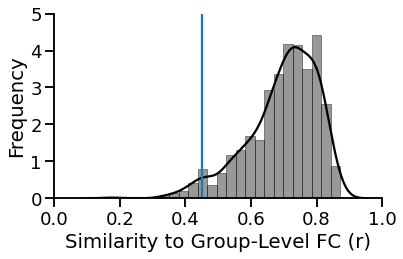

In [61]:
sns.set_context("talk", font_scale=1.1)
ax = sns.distplot(DF['corrDG'], 
                  hist_kws=dict(edgecolor="k", linewidth=1),
                  color='k')
sns.despine()
ax.set(xlim=(0,1))
ax.set(ylim=(0,5))
ax.set(ylabel='Frequency')
ax.set(xlabel='Similarity to Group-Level FC (r)')
plt.axvline(0.45, 0, 5)
plt.tight_layout()
#plt.savefig('../hippocampus/figures/qc_corr_dg.png',dpi=300)

In [68]:
DF['corrSUB'].mean(), DF['corrSUB'].mean() - 2.5 * DF['corrSUB'].std()

(0.7535437658284636, 0.5339926400963128)

In [69]:
DF['corrCA'].mean(), DF['corrCA'].mean() - 2.5 * DF['corrCA'].std()

(0.7234251286665159, 0.46755916163952)

In [70]:
DF['corrDG'].mean(), DF['corrDG'].mean() - 2.5 * DF['corrDG'].std()

(0.6964798019368342, 0.42801988425049764)

# add HCP demographics to the DF


In [96]:
subjlist = '../data/subjectList1200.txt'
f = open(subjlist); mylist = f.read().split("\n"); f.close() 
subjlist = joinedlist = mylist[:-1]
len(subjlist)

1113

In [97]:
HCP_u = pd.read_csv('../data/HCP_solar/HCP_s1200_unrestricted.csv', 
                    index_col = 0)

HCP_u.index = HCP_u.index.map(str)

HCP_r = pd.read_csv('../data/HCP_solar/HCP_s1200_restricted.csv', 
                    index_col = 0)

HCP_r.index = HCP_r.index.map(str)

In [104]:
DF['sex'] = DF['sex'].astype(str)
DF['ZygositySR'] = DF['ZygositySR'].astype(str)

In [105]:
female = 0
MZ = 0
NotMZ = 0
NotTwin = 0

for subjID in subjlist:
    
    iA = HCP_r.index.get_loc(subjID)
    iB = HCP_u.index.get_loc(subjID)
    iC = DF.index.get_loc(subjID)

    DF.at[subjID, 'age'] = HCP_r.iloc[iA]['Age_in_Yrs']
    DF.at[subjID, 'sex'] = HCP_u.iloc[iB]['Gender']
    DF.at[subjID, 'ZygositySR'] = HCP_r.iloc[iA]['ZygositySR']
    
   
    if check.at[subjID, 'sex'] == 'F':
        female += 1
    if check.at[subjID, 'ZygositySR'] == 'MZ':
        MZ += 1
    if check.at[subjID, 'ZygositySR'] == 'NotMZ':
        NotMZ += 1
    if check.at[subjID, 'ZygositySR'] == 'NotTwin':
        NotTwin += 1



### mean and std of AGE of subjects included in study

In [120]:
DF[DF['INCLUSION'] == 1]['age'].mean(), DF[DF['INCLUSION'] == 1]['age'].std()

(28.708039492242595, 3.7224627681932634)

### number of females included

In [125]:
len(DF[(DF.INCLUSION == 1) & (DF.sex == 'F')])

395

### twin status of subjects included

In [128]:
MZ = len(DF[(DF.INCLUSION == 1) & (DF.ZygositySR == 'MZ')])

NotMZ = len(DF[(DF.INCLUSION == 1) & (DF.ZygositySR == 'NotMZ')])

NotTwin = len(DF[(DF.INCLUSION == 1) & (DF.ZygositySR == 'NotTwin')])



In [129]:
MZ, NotMZ, NotTwin

(176, 178, 354)

In [130]:
MZ + NotMZ + NotTwin

708

In [131]:
DF.to_excel('../data/qualityControl_Bayrak.xlsx')

In [132]:
47 + 69 + 42 + 31

189

In [133]:
898 - 189

709

In [149]:
m = 0    
y = 0
h = 0
k = 0

for subjS900 in DF_pnas.index:
    if pd.isnull(DF.at[subjS900, 'HCP-issues']):
        y += 1

        if DF.at[subjS900, '4scans'] == 1:
            m += 1

            if DF.at[subjS900, 'pnas'] > 0  or DF.at[subjS900, 't1-t2-man-viz'] == 1: 
                h += 1
                
                    

In [146]:
y

851

In [147]:
m

782

In [148]:
h

406

In [150]:
h

740

In [151]:
740 - 460

280

In [155]:
DF_pnas['Grade'] != np.NaN

Subjects
100206    True
100307    True
100408    True
100610    True
101006    True
          ... 
992673    True
992774    True
993675    True
994273    True
996782    True
Name: Grade, Length: 898, dtype: bool

In [158]:
DF_pnas[~DF_pnas['Grade'].isnull()]

,Comments,Grade,Inclusion,Recheck
Subjects,,,,
100408,NaN,2.0,1,0
100610,NaN,3.0,1,0
101006,NaN,3.0,1,0
102513,NaN,3.0,1,0
102816,NaN,3.0,1,0
...,...,...,...,...
958976,NaN,2.0,1,0
966975,NaN,3.0,1,0
987983,NaN,3.0,1,0


In [159]:
898 - 399

499